In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
import copy
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:

data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)

data.head(5)

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1900052301.000,2019-06-04,ZB00025746,1,9.412,0.000,9.412,0.000,9.412,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1900100835.000,2019-07-15,ZB00025746,1,8.649,5.393,8.649,5.393,3.255,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1900106577.000,2019-07-24,ZB00025746,1,8.649,5.459,8.649,5.459,3.190,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1900111398.000,2019-08-01,ZB00025746,1,8.649,5.440,8.649,5.440,3.209,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1900052301.000,2019-06-04,ZB00022010,1,12.785,4.088,12.785,4.088,8.697,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [ ]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'MS'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [ ]:
daily_sales=select_series(data)
daily_sales.columns=['date', 'sales']
daily_sales.head()

,date,sales
0,2019-06-01,27686.366
1,2019-06-02,3511.560
2,2019-06-03,7006.124
3,2019-06-04,80530.521
4,2019-06-05,86484.288


In [ ]:
# Let’s take a look into the basic statistics of our dataset
daily_sales.describe()

,sales
count,707.000
mean,57665.109
std,25543.759
min,169.507
25%,40163.517
50%,52106.057
75%,71965.858
max,223637.603


<Figure size 1080x576 with 0 Axes>

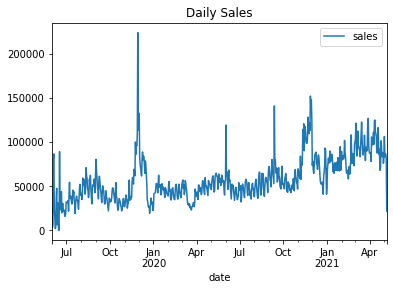

In [ ]:
fig=plt.figure(figsize=(15, 8))
daily_sales.plot('date', 'sales')
plt.title('Daily Sales')
plt.show()

In [ ]:
daily_sales.head()

,date,sales
0,2019-06-01,27686.366
1,2019-06-02,3511.560
2,2019-06-03,7006.124
3,2019-06-04,80530.521
4,2019-06-05,86484.288


In [ ]:
daily_sales['Date']=pd.to_datetime(daily_sales['date']).dt.date

In [ ]:
#train_df.reset_index('date', inplace=True)

In [ ]:
# Creating time-series features for XGBoost
daily_sales.set_index('date', inplace=True)
daily_sales['Year']=pd.to_datetime(daily_sales['Date']).dt.year
daily_sales['Week'] = pd.to_datetime(daily_sales['Date']).dt.week
daily_sales['Day'] = pd.to_datetime(daily_sales['Date']).dt.day
daily_sales['WeekDay'] = pd.to_datetime(daily_sales['Date']).dt.dayofweek
daily_sales['Weekend'] = daily_sales.WeekDay.isin([5, 6]).astype(int)
daily_sales.head()

,sales,Date,Year,Week,Day,WeekDay,Weekend
date,,,,,,,
2019-06-01,27686.366,2019-06-01,2019,22,1,5,1
2019-06-02,3511.560,2019-06-02,2019,22,2,6,1
2019-06-03,7006.124,2019-06-03,2019,23,3,0,0
2019-06-04,80530.521,2019-06-04,2019,23,4,1,0
2019-06-05,86484.288,2019-06-05,2019,23,5,2,0


In [ ]:
# lets check their correlation
daily_sales.corr()

,sales,Year,Week,Day,WeekDay,Weekend
sales,1.000,0.533,-0.027,-0.040,-0.115,-0.062
Year,0.533,1.000,-0.571,-0.030,0.001,-0.005
Week,-0.027,-0.571,1.000,0.059,0.001,0.001
Day,-0.040,-0.030,0.059,1.000,0.011,0.005
WeekDay,-0.115,0.001,0.001,0.011,1.000,0.791
Weekend,-0.062,-0.005,0.001,0.005,0.791,1.000


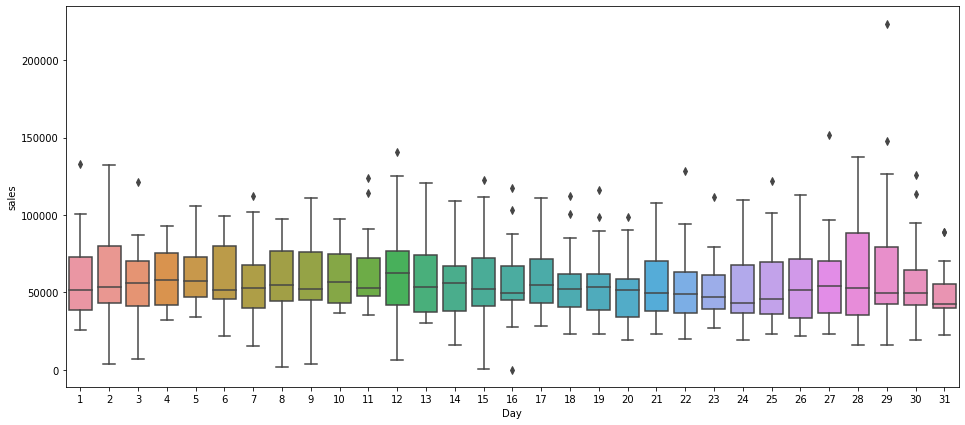

In [ ]:
fig=plt.subplots(figsize=(16, 7))
sns.boxplot(daily_sales['Day'], daily_sales['sales'])
plt.show()

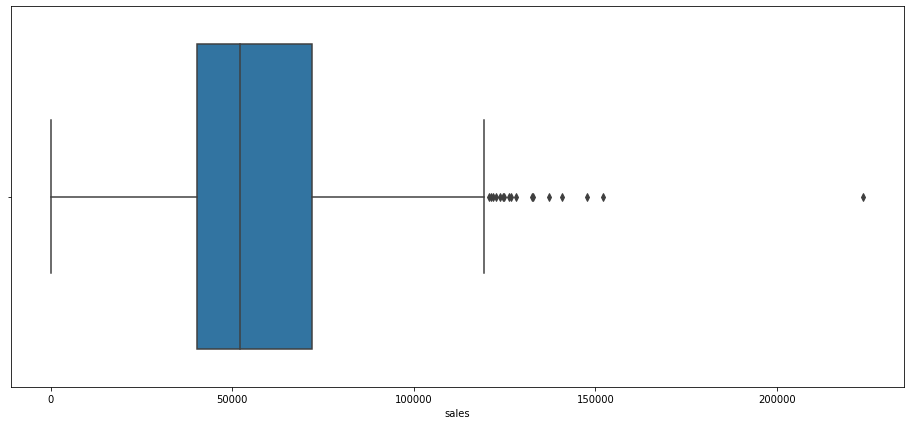

In [ ]:
# let's see if there is any outlier
fig=plt.subplots(figsize=(16, 7))
sns.boxplot(x=daily_sales['sales'])
plt.show()

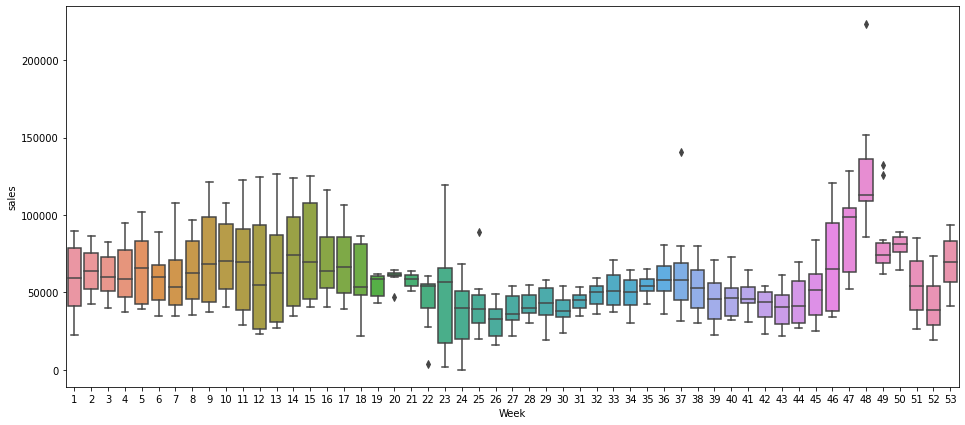

In [ ]:
fig=plt.subplots(figsize=(16, 7))
sns.boxplot(daily_sales['Week'], daily_sales['sales'])
plt.show()

It seems like there is a yearly seasonality. So, a feature should capture it. 


In [ ]:
train_df=daily_sales[:int(daily_sales.shape[0]*0.90)]
test_df=daily_sales[int(daily_sales.shape[0]*0.90):]
print(train_df.shape)
print(test_df.shape)

(636, 7)
(71, 7)


There was weekly seasonality. So, let's create some features to capture them.


In [ ]:
#Let's create time series features for the model
def create_features(df, label=None):
 df['date'] = df.index
 df['hour'] = df['date'].dt.hour
 df['dayofweek'] = df['date'].dt.dayofweek
 df['quarter'] = df['date'].dt.quarter
 df['month'] = df['date'].dt.month
 df['year'] = df['date'].dt.year
 df['dayofyear'] = df['date'].dt.dayofyear
 df['dayofmonth'] = df['date'].dt.day
 df['weekofyear'] = df['date'].dt.weekofyear
 X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
 if label:
   y = df[label]
   return X, y
 return X
X_train, y_train = create_features(train_df, label='sales')
X_test, y_test = create_features(test_df, label='sales')

In [ ]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2019-06-01,5,2,6,2019,152,1,22
2019-06-02,6,2,6,2019,153,2,22
2019-06-03,0,2,6,2019,154,3,23
2019-06-04,1,2,6,2019,155,4,23
2019-06-05,2,2,6,2019,156,5,23


In [ ]:
y_train.head()

date
2019-06-01   27686.366
2019-06-02    3511.560
2019-06-03    7006.124
2019-06-04   80530.521
2019-06-05   86484.288
Name: sales, dtype: float64

In [ ]:
# Training the XGBoost model
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4, 8]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000)
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
gridcv_xgb
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

-0.3935113833547088


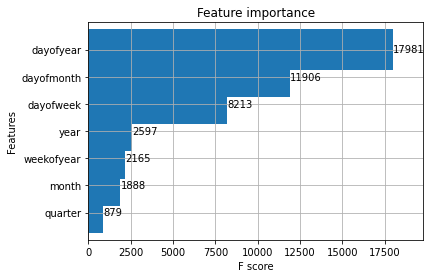

In [ ]:
#Let's take a look into feature importance

_=plot_importance(gridcv_xgb, height=1.5)

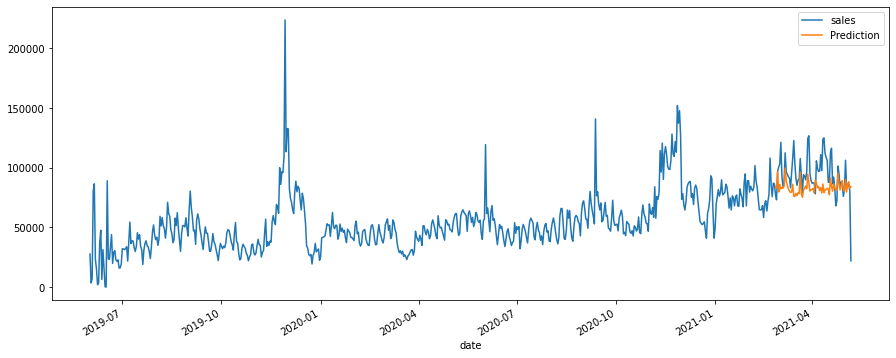

In [ ]:
# Evaluate the model
test_df['Prediction']=gridcv_xgb.predict(X_test)
comp_df=pd.concat([test_df, train_df], sort=False)
_=comp_df[['sales', 'Prediction']].plot(figsize=(15, 6))

In [ ]:
# Model Evaluation 
def mean_absolute_percentage_error(y_true, y_pred): 
  #Calculates MAPE given y_true and y_pred
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
  
mean_absolute_percentage_error(y_true=test_df['sales'], y_pred=test_df['Prediction'])

16.97552377271444

Let's remove some features from x_train and see if it improves the model's performance


,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2021-02-26,4,1,2,2021,57,26,8
2021-02-27,5,1,2,2021,58,27,8
2021-02-28,6,1,2,2021,59,28,8
2021-03-01,0,1,3,2021,60,1,9
2021-03-02,1,1,3,2021,61,2,9


In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    X = df[['dayofweek', 'dayofyear', 'dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X
X_train_new, y_train_new = create_features(train_df, label='sales')
X_test_new, y_test_new = create_features(test_df, label='sales')

In [ ]:
# Training the XGBoost model without less importance features
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4, 8]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000)
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train_new, y_train_new)
gridcv_xgb = grid.best_estimator_
gridcv_xgb
print(r2_score(y_test_new, gridcv_xgb.predict(X_test_new)))

-10.313017549795664


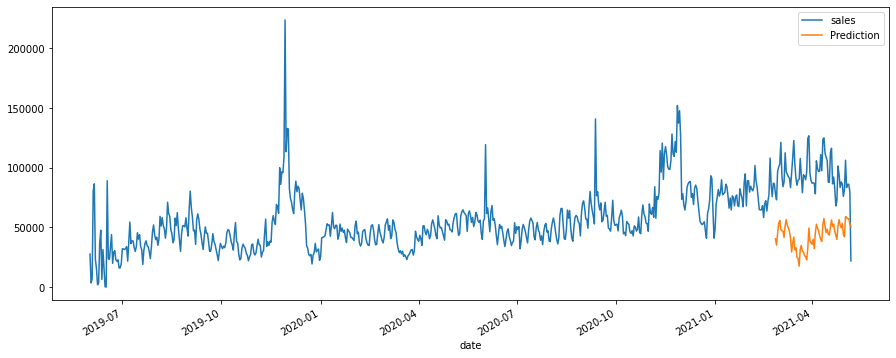

In [ ]:
# Evaluate the model once again
test_df['Prediction']=gridcv_xgb.predict(X_test_new)
comp_df=pd.concat([test_df, train_df], sort=False)
_=comp_df[['sales', 'Prediction']].plot(figsize=(15, 6))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  #Calculates MAPE given y_true and y_pred
  y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
  
mean_absolute_percentage_error(y_true=test_df['sales'], y_pred=test_df['Prediction'])

54.67438562040513